# 使用校正后的数据进行训练

In [1]:
#!AHOCORASICK_BYTES=1 pip install git+https://github.com/WojciechMula/pyahocorasick.git

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import random
from tokenizer import tokenizer,token2str,vocab_size
import torch
import torch.nn as nn
from make_model import make_model
from train_and_use import Batch,CrossEntropyLoss,SimpleAdamOptimizer,OptimizerWrapper,train_server_start
from train_and_use import text_continue
from train_and_use import TOGGLE,STOP
from train_and_use import record
from collections import Counter,defaultdict
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# %matplotlib widget

In [3]:
model = make_model(
    #token是从1开始的，0填充，剩下的用来覆盖全部字节
    vocab_size = vocab_size+1+255,
    embedding_dim = 512,
    key_dim = 256,
    head_number = 8,
    position_information_type = "mask",
    # position_information_type = "sinusoidal",
    # position_information_type = "rotary",
    # position_information_type = "learned",
    enable_affine = True,
    enable_talking_head = True,
    use_diff = False,
    self_attention_block_size = 0,
    feed_forward_dim = 1024,
    enable_layer_norm = True,
    deep = 6,
    dropout_rate = 0.1
).to(device)

In [4]:
lines = []
with open('low.txt','r') as f:
    temp = [(line[:-1],' 这段文本的质量按照“高、中、低”三档评价为：低') for line in f if len(line) > 16]
    lines += random.sample(temp,800)
with open('mid.txt','r') as f:
    temp = [(line[:-1],' 这段文本的质量按照“高、中、低”三档评价为：中') for line in f if len(line) > 16]
    lines += random.sample(temp,800)
with open('high.txt','r') as f:
    temp = [(line[:-1],' 这段文本的质量按照“高、中、低”三档评价为：高') for line in f if len(line) > 16]
    lines += random.sample(temp,800)

In [5]:
def data_generator(batch_size):
    #将各等级的数据打乱
    np.random.shuffle(lines)
    for i in range(0,len(lines),batch_size):
        data = [tokenizer(line[0],1.0) for line in lines[i:i+batch_size]]
        label = [tokenizer(line[1],5.0) for line in lines[i:i+batch_size]]
        trunk = [(s + [-255]*1000)[:1000]+l for s,l in zip(data,label)]
        trunk = np.array(trunk,dtype=np.int64)+255
        inputs = torch.from_numpy(trunk).to(device).data
        ret = Batch(inputs)
        ret.label = ret.label.clone()
        #只预测最后的标签
        ret.label[:,:-1] = 0
        ret.ntokens = ret.label.size(0)
        yield ret

In [6]:
model.load_state_dict(torch.load('large_model_2.907_.weight',weights_only=True))
model.train()
loss_f = CrossEntropyLoss()
optimizer = OptimizerWrapper(
    optimizer = SimpleAdamOptimizer(model.parameters(),betas = (0.9,0.98),eps = 1e-7),
    warm_up = 200,
    lr = 1e-4
)
split_n    = 24#资源不够时，累积梯度的方式模拟大批次
batch_size = split_n * 2
train_server_start(model,(data_generator,batch_size),split_n,loss_f,optimizer,use_amp = False)

epoch: 29 	step: 19 	loss: 0.017 	speed: 6.01017 tokens/s                    

In [34]:
# TOGGLE()
# STOP()

In [29]:
# optimizer.set_lrate(1e-5,200)

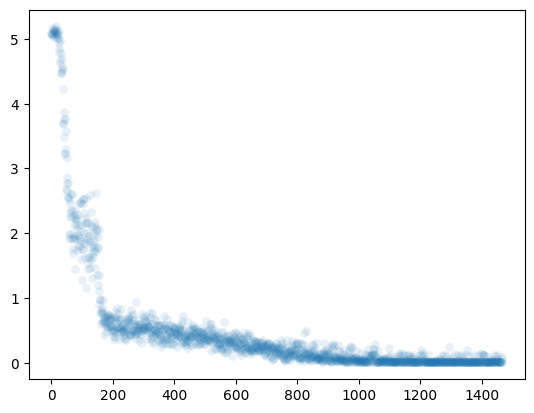

In [31]:
plt.close()
plt.scatter(list(range(len(record['loss_line']))),record['loss_line'],alpha=0.1,linewidths=0.1)
# plt.plot(record['loss_line'])
plt.show()

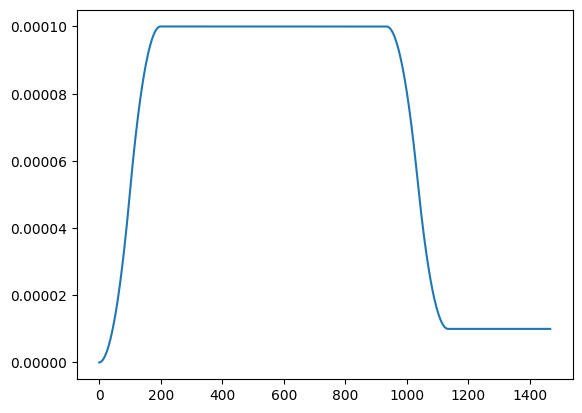

In [32]:
plt.close()
# plt.plot(record['loss_line'])
plt.plot(record['lr_line'])
plt.show()

In [35]:
result = []
check = defaultdict(list)
for i in tqdm(range(len(lines))):
    tokens_batch = [(tokenizer(lines[i][0],5.0)+[-255]*1000)[:1000] + tokenizer(lines[i][1],5.0)[:-1]]
    tokens_batch = np.array(tokens_batch,dtype=np.int64)+255
    inputs = torch.from_numpy(tokens_batch).to(device).data
    model = model.eval()
    with torch.no_grad():
        o = text_continue(
            model,inputs,out_length=1,
            repeat_penalty_value = 0.0,
            temperature = 0.01
        )
    res = (lines[i][1][-1],token2str(o[0].cpu().numpy()-255)[-1])
    result += [res]
    check[res[0]+'->'+res[1]] += [i]
    model = model.train()
print(Counter(result))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2400/2400 [03:54<00:00, 10.22it/s]

Counter({('中', '中'): 793, ('高', '高'): 791, ('低', '低'): 674, ('低', '中'): 125, ('高', '中'): 9, ('中', '低'): 5, ('中', '高'): 2, ('低', '高'): 1})


In [83]:
restype = check['低->中']
i = restype[np.random.randint(len(restype))]
lines[i]

('避风港货币（Safe Haven Currency）是投资者和基金经理在政治动荡时期欲为资金寻找避风港时，将资金投入的货币。避风港货币指诸如美元或瑞士法郎等主要交易货币，投资者和基金经理在政治动荡时期欲为资金寻找避风港时，即会将资金投入此类货币。',
 ' 这段文本的质量按照“高、中、低”三档评价为：低')

In [84]:
torch.save(model.state_dict(),'autotagger_train.weight')